# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFlite_Version  = "1105"   
TFlite_MainType = "ana-cont"
TFlite_Size     = "s2"
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(6633, 32, 32, 3)
(6633, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(4,4))(inputs3)
inputs5 = tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(128,activation="relu")(inputs9)
inputs11 = tf.keras.layers.Dense(64,activation="relu")(inputs10)
output = tf.keras.layers.Dense(2)(inputs11)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          12816     
                                             

2023-02-18 20:46:21.950653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-18 20:46:21.950817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 conv2d_2 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 44,798
Trainable params: 44,792
Non-trainable params: 6
_________________________________________________________________


# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/30


/var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/ipykernel_74280/3831122756.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
2023-02-18 20:46:22.230028: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-18 20:46:22.500469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


827/830 [============================>.] - ETA: 0s - loss: 0.1890 - accuracy: 0.8375

2023-02-18 20:46:33.509125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


830/830 [==============================] - 13s 15ms/step - loss: 0.1886 - accuracy: 0.8376 - val_loss: 0.0867 - val_accuracy: 0.9081
Epoch 2/30
830/830 [==============================] - 12s 14ms/step - loss: 0.0474 - accuracy: 0.9459 - val_loss: 0.0408 - val_accuracy: 0.9488
Epoch 3/30
830/830 [==============================] - 12s 14ms/step - loss: 0.0329 - accuracy: 0.9593 - val_loss: 0.0255 - val_accuracy: 0.9714
Epoch 4/30
830/830 [==============================] - 12s 14ms/step - loss: 0.0237 - accuracy: 0.9596 - val_loss: 0.0147 - val_accuracy: 0.9631
Epoch 5/30
830/830 [==============================] - 12s 14ms/step - loss: 0.0177 - accuracy: 0.9644 - val_loss: 0.0065 - val_accuracy: 0.9774
Epoch 6/30
830/830 [==============================] - 12s 14ms/step - loss: 0.0140 - accuracy: 0.9673 - val_loss: 0.0082 - val_accuracy: 0.9683
Epoch 7/30
830/830 [==============================] - 11s 14ms/step - loss: 0.0118 - accuracy: 0.9730 - val_loss: 0.0073 - val_accuracy: 0.9751
Epo

### Step 1: Learing result
 
* Visualization of the training and validation results

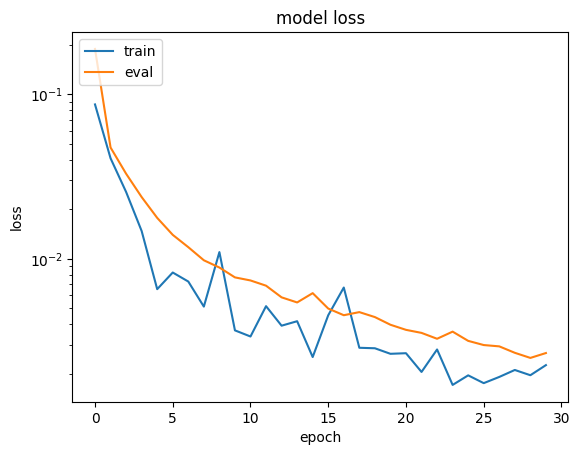

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 160
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/160
 13/830 [..............................] - ETA: 7s - loss: 0.5685 - accuracy: 0.4845

/var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/ipykernel_74280/1492021130.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


830/830 [==============================] - 9s 10ms/step - loss: 0.1245 - accuracy: 0.8821 - val_loss: 0.0596 - val_accuracy: 0.9375
Epoch 2/160
830/830 [==============================] - 9s 10ms/step - loss: 0.0472 - accuracy: 0.9441 - val_loss: 0.0529 - val_accuracy: 0.9540
Epoch 3/160
830/830 [==============================] - 9s 11ms/step - loss: 0.0368 - accuracy: 0.9528 - val_loss: 0.0225 - val_accuracy: 0.9631
Epoch 4/160
830/830 [==============================] - 9s 11ms/step - loss: 0.0290 - accuracy: 0.9581 - val_loss: 0.0274 - val_accuracy: 0.9586
Epoch 5/160
830/830 [==============================] - 9s 10ms/step - loss: 0.0238 - accuracy: 0.9613 - val_loss: 0.0202 - val_accuracy: 0.9706
Epoch 6/160
830/830 [==============================] - 9s 11ms/step - loss: 0.0231 - accuracy: 0.9632 - val_loss: 0.0188 - val_accuracy: 0.9601
Epoch 7/160
830/830 [==============================] - 9s 10ms/step - loss: 0.0200 - accuracy: 0.9653 - val_loss: 0.0240 - val_accuracy: 0.9623
Epoc

### Overall Learing results (Step 1 & Step 2)

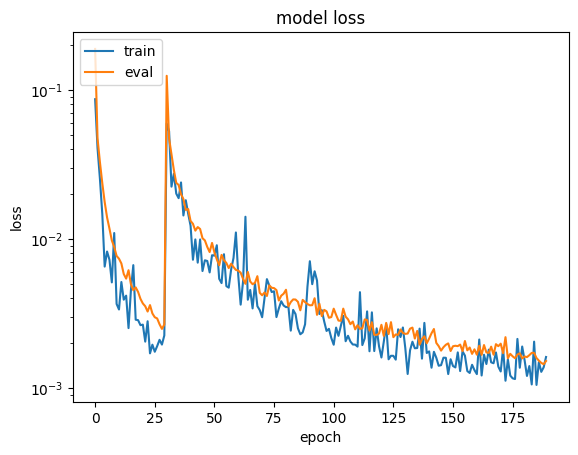

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in sorted(files):
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img, verbose=0)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

2023-02-18 21:19:36.722550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


data_resize_all/0.0_0003_zeiger1_2019-06-04T044009.jpg 0.0 0.05588433268420276 -0.05588433268420276
data_resize_all/0.0_0028_zeiger4_2019-06-04T134009.jpg 0.0 0.0583985158313106 -0.0583985158313106
data_resize_all/0.0_0032_zeiger4_2019-06-04T234009.jpg 0.0 0.05925186259073907 -0.05925186259073907
data_resize_all/0.0_0033_zeiger4_2019-06-04T235009.jpg 0.0 0.05897554349331667 -0.05897554349331667
data_resize_all/0.0_0034_zeiger4_2019-06-05T000009.jpg 0.0 0.05999169540071147 -0.05999169540071147
data_resize_all/0.0_0035_zeiger4_2019-06-05T002009.jpg 0.0 0.05856079922871534 -0.05856079922871534
data_resize_all/0.0_0037_zeiger4_2019-06-05T005009.jpg 0.0 0.05299817933217079 -0.05299817933217079
data_resize_all/0.0_0038_zeiger4_2019-06-05T010010.jpg 0.0 0.06117071886068953 -0.06117071886068953
data_resize_all/0.0_0039_zeiger4_2019-06-05T011009.jpg 0.0 0.05702603200627886 -0.05702603200627886
data_resize_all/0.0_0040_zeiger4_2019-06-05T013009.jpg 0.0 0.060243288264701045 -0.060243288264701045


## Results

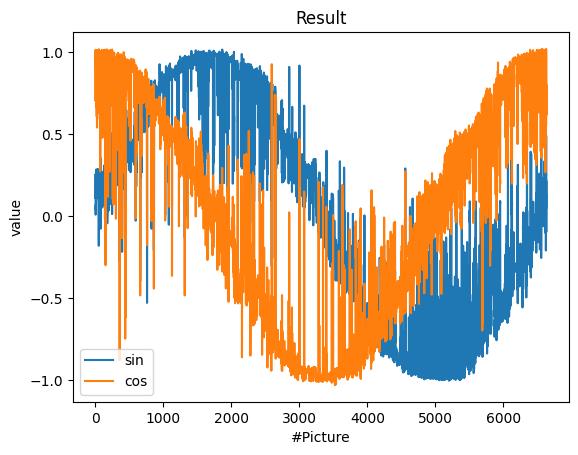

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

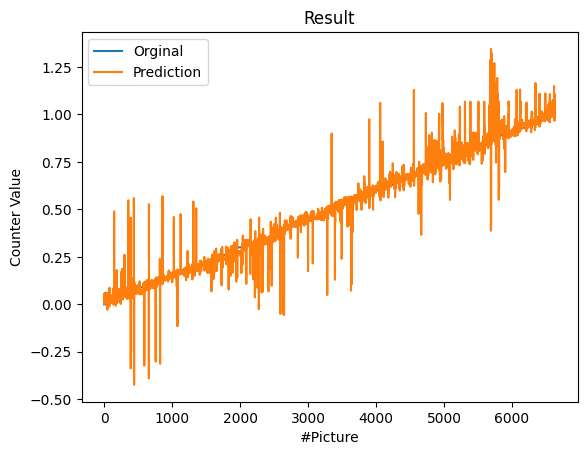

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

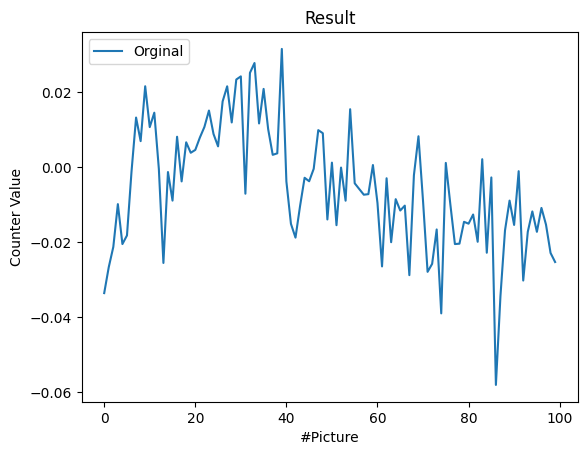

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

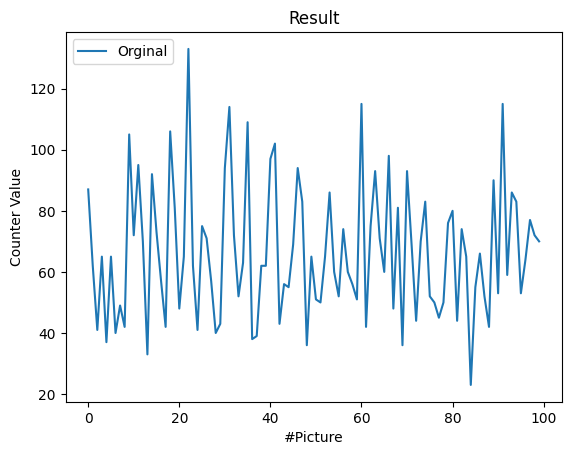

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

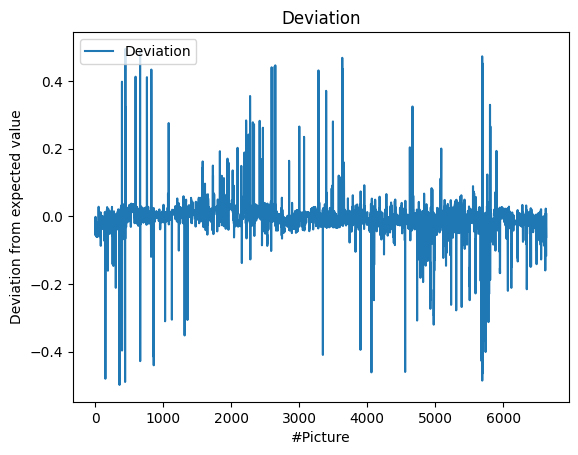

[-0.0049  0.0502 -0.4981  0.4947]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmph4r_jv_0/assets


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmph4r_jv_0/assets
2023-02-18 21:22:25.578856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-18 21:22:25.578874: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-18 21:22:25.579286: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmph4r_jv_0
2023-02-18 21:22:25.580668: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-02-18 21:22:25.580674: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmph4r_jv_0
2023-02-18 21:22:25.584510: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-18 21:22:25.585725: I tensorflow/cc/saved_model/load

183756

In [16]:
from pathlib import Path
import tensorflow as tf

FileName = FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + "_q.tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[n], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpie5g5nj0/assets


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpie5g5nj0/assets
/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-02-18 21:47:29.499620: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-18 21:47:29.499633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


ana-cont_1105_s2_q.tflite


2023-02-18 21:47:29.499716: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpie5g5nj0
2023-02-18 21:47:29.501221: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-02-18 21:47:29.501227: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpie5g5nj0
2023-02-18 21:47:29.506388: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-02-18 21:47:29.554318: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmpie5g5nj0
2023-02-18 21:47:29.569941: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 70226 microseconds.
fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


53328